# Summary
I begin developing a model for predicting wildfire size class with basic scraped features. Major point established so far is that scaling 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import time

from sklearn.model_selection import train_test_split

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix

# ignore warning when preds doesn't predict rare class
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

/home/douglas/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Set global random seed for sklearn
np.random.seed(2019) 

In [4]:
data = pd.read_pickle('train_fires.pkl')

# Develop pipeline
Use a smaller subset to develop code and work through issues

In [5]:
train, _  = train_test_split(data, test_size=0.8, stratify=data['CLASS'])
# switching over to 3 class problem for easier interpretation of results
# Small(1): < 10 acres burned (A,B)
# Medium(2): 10-1000 acres (C, D, E)
# Large(3): > 1000 acres (F,G)

In [6]:
train.shape

(310542, 32)

In [7]:
train['FIRE_SIZE_CLASS'].value_counts()

B    157827
A    107857
C     36243
D      4613
E      2232
F      1193
G       577
Name: FIRE_SIZE_CLASS, dtype: int64

In [8]:
train['CLASS'].value_counts()

1    271506
2     37340
3      1696
Name: CLASS, dtype: int64

In [9]:
train = train.drop(columns='FIRE_SIZE_CLASS')
train.shape

(310542, 31)

/home/douglas/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


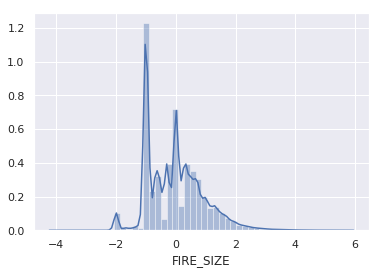

In [10]:
sns.distplot(np.log10(train['FIRE_SIZE']))
# not log normal - big peak of fires less than 1 acre
# partly why I did classification since the exact size is unimportant
# more important is the response needed
# 1: local firefighters, 2: maybe several teams, 3: bring in reinforcements, feds

In [11]:
train.dtypes

FOD_ID                       int64
DISCOVERY_DATE      datetime64[ns]
FIRE_SIZE                  float64
LATITUDE                   float64
LONGITUDE                  float64
Month                        int64
DayofWeek                   object
COUNTY2_x                   object
COUNTY_ID                   object
CLASS                     category
StateID                     object
Elevation                  float64
weather_station1            object
stn_x                       object
year_x                      object
temp_x                     float64
stp_x                      float64
wdsp_x                     float64
max_temp_x                 float64
prcp_x                     float64
thunder_x                   object
date_x              datetime64[ns]
day_2               datetime64[ns]
year_day2                   object
temp_day2                  float64
stp_day2                   float64
wdsp_day2                  float64
max_temp_day2              float64
prcp_day2           

In [12]:
# template for scaling when some cols are not suited
# scaler = StandardScaler()
# X_subset = scaler.fit_transform(X[:,[0,1]])
# X_last_column = X[:, 2]
# X_std = np.concatenate((X_subset, X_last_column[:, np.newaxis]), axis=1)

In [66]:
def cv_features(model, train, target, splits=5):
    
    starttime = time.time()
    # separate input df into features and target
    print("original length", len(train))
    train = train.dropna() # just drop for now
    print("dropped na's", len(train))
    y = train[target]
    X = train.drop(columns=target)
    # get indices to look up float columns 
#     float_indices = [i for i, col in enumerate(X.columns) if X[col].dtype == 'float64']
    
     
    kf = StratifiedKFold(n_splits=splits)
#     imp = Imputer()
    scaler = StandardScaler()
    fs = []
    ps = []
    rs = []
    classes = [1,2,3]
    
    for train_ind, val_ind in kf.split(X, y):
        # split data on indices
        # "take" indexes according to position of element, not index values
        train_X = X.take(train_ind)
        train_y = y.take(train_ind)
#         print('train', train_y.value_counts()/len(train_y)) # confirm kf worked
        val_X = X.take(val_ind)
        val_y = y.take(val_ind)
#         print('val', val_y.value_counts()/len(train_y))
        # normalize float columns for train
        float_cols = train_X.select_dtypes(include='float64')

        float_cols = scaler.fit_transform(float_cols)
        # recombine 
        other_cols = train_X.select_dtypes(exclude='float64')
        train_X_norm = np.concatenate((float_cols, other_cols), axis=1)
        
        # fit model    
        model.fit(train_X_norm, train_y)
        
        # normalize float columns for val
        float_cols = val_X.select_dtypes(include='float64')

        float_cols = scaler.transform(float_cols)
        other_cols = val_X.select_dtypes(exclude='float64')
        val_X_norm = np.concatenate((float_cols, other_cols), axis=1)
        
        # predict 
        model_preds = model.predict(val_X_norm)
        
        # generate scores
        fs.append(f1_score(val_y, model_preds, labels=classes, average=None))
        ps.append(precision_score(val_y, model_preds, labels=classes, average=None))
        rs.append(recall_score(val_y, model_preds, labels=classes, average=None))
    
    endtime = time.time()
    print('Run time:', endtime - starttime)
    # print last one
    print(confusion_matrix(val_y, model_preds, labels=classes)) 
    print(classification_report(val_y, model_preds, labels=classes))
    
    # return mean over the 5 folds
    print('f1 -- precision -- recall')
    return np.mean(fs,axis=0), np.mean(ps,axis=0), np.mean(rs,axis=0)
        

In [15]:
# Start with old baseline

In [67]:
lr = LogisticRegression(C=10000)

In [68]:
df1 = train[['LONGITUDE', 'CLASS']]
cv_features(lr, df1, 'CLASS')

original length 310542
dropped na's 310542
Run time: 2.960841417312622
[[54301     0     0]
 [ 7468     0     0]
 [  339     0     0]]
             precision    recall  f1-score   support

          1       0.87      1.00      0.93     54301
          2       0.00      0.00      0.00      7468
          3       0.00      0.00      0.00       339

avg / total       0.76      0.87      0.82     62108

f1 -- precision -- recall


(array([0.93293337, 0.        , 0.        ]),
 array([0.8742972, 0.       , 0.       ]),
 array([1., 0., 0.]))

In [18]:
# try most promising feature from weather data as alternative logit baseline
df2 = train[['max_temp_x', 'CLASS']]
cv_features(lr, df2, 'CLASS')

original length 310542
dropped na's 310314
Run time: 5.724637508392334
[[54265     0     0]
 [ 7459     0     0]
 [  338     0     0]]
             precision    recall  f1-score   support

          1       0.87      1.00      0.93     54265
          2       0.00      0.00      0.00      7459
          3       0.00      0.00      0.00       338

avg / total       0.76      0.87      0.82     62062

f1 -- precision -- recall


(array([0.93296885, 0.        , 0.        ]),
 array([0.87435952, 0.        , 0.        ]),
 array([1., 0., 0.]))

In [19]:
# Move on to vanilla random forest, keeping number of trees low for run time
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
cv_features(rf, df2, 'CLASS')

original length 310542
dropped na's 310314
Run time: 82.87573313713074
[[37925 16340     0]
 [ 5423  2036     0]
 [  190   148     0]]
             precision    recall  f1-score   support

          1       0.87      0.70      0.78     54265
          2       0.11      0.27      0.16      7459
          3       0.00      0.00      0.00       338

avg / total       0.77      0.64      0.70     62062

f1 -- precision -- recall


(array([0.80104555, 0.1265181 , 0.        ]),
 array([0.8716049 , 0.08794594, 0.        ]),
 array([0.75000963, 0.22677051, 0.        ]))

In [20]:
train.columns

Index(['FOD_ID', 'DISCOVERY_DATE', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE',
       'Month', 'DayofWeek', 'COUNTY2_x', 'COUNTY_ID', 'CLASS', 'StateID',
       'Elevation', 'weather_station1', 'stn_x', 'year_x', 'temp_x', 'stp_x',
       'wdsp_x', 'max_temp_x', 'prcp_x', 'thunder_x', 'date_x', 'day_2',
       'year_day2', 'temp_day2', 'stp_day2', 'wdsp_day2', 'max_temp_day2',
       'prcp_day2', 'thunder_day2', 'date_day2'],
      dtype='object')

In [21]:
# Add more weather features
df3 = train[['wdsp_x','max_temp_x', 'prcp_x', 'CLASS']]
cv_features(rf, df3, 'CLASS')

original length 310542
dropped na's 298428
Run time: 123.5555477142334
[[51790   377     0]
 [ 7131    63     0]
 [  318     5     0]]
             precision    recall  f1-score   support

          1       0.87      0.99      0.93     52167
          2       0.14      0.01      0.02      7194
          3       0.00      0.00      0.00       323

avg / total       0.78      0.87      0.81     59684

f1 -- precision -- recall


(array([0.92695268, 0.02126689, 0.        ]),
 array([0.87428867, 0.07373504, 0.        ]),
 array([0.9866544 , 0.01504031, 0.        ]))

In [22]:
# Bring in more weather, including day 2, and class weights
df4 = train[['wdsp_x','max_temp_x', 'prcp_x','thunder_x', 'wdsp_day2',
       'max_temp_day2', 'CLASS']]
rfw = RandomForestClassifier(n_estimators=300, 
                             class_weight={1:1, 2:5, 3:80})
cv_features(rfw, df4, 'CLASS')

original length 310542
dropped na's 295368
Run time: 378.57324719429016
[[51626     0     0]
 [ 7129     0     0]
 [  318     0     0]]
             precision    recall  f1-score   support

          1       0.87      1.00      0.93     51626
          2       0.00      0.00      0.00      7129
          3       0.00      0.00      0.00       318

avg / total       0.76      0.87      0.82     59073

f1 -- precision -- recall


(array([9.31209540e-01, 4.45558340e-04, 9.85221675e-04]),
 array([8.73839345e-01, 3.01886792e-02, 6.66666667e-04]),
 array([9.96664471e-01, 2.24435405e-04, 1.88679245e-03]))

In [23]:
# Try something different
df5 = train[['LONGITUDE', 'Elevation', 'max_temp_x','CLASS']]
cv_features(rfw, df5, 'CLASS')

original length 310542
dropped na's 310314
Run time: 437.46885800361633
[[54265     0     0]
 [ 7459     0     0]
 [  338     0     0]]
             precision    recall  f1-score   support

          1       0.87      1.00      0.93     54265
          2       0.00      0.00      0.00      7459
          3       0.00      0.00      0.00       338

avg / total       0.76      0.87      0.82     62062

f1 -- precision -- recall


(array([0.93296885, 0.        , 0.        ]),
 array([0.87435952, 0.        , 0.        ]),
 array([1., 0., 0.]))

In [33]:
# Try balanced class weights
rfwb = RandomForestClassifier(n_estimators=300, 
                             class_weight="balanced",
                             n_jobs=-1)
cv_features(rfwb, df3, 'CLASS')

original length 310542
dropped na's 298428
Run time: 126.36591100692749
[[51989   178     0]
 [ 7168    26     0]
 [  322     1     0]]
             precision    recall  f1-score   support

          1       0.87      1.00      0.93     52167
          2       0.13      0.00      0.01      7194
          3       0.00      0.00      0.00       323

avg / total       0.78      0.87      0.81     59684

f1 -- precision -- recall


(array([0.92884825, 0.01518054, 0.        ]),
 array([0.87411022, 0.09476372, 0.        ]),
 array([0.99101349, 0.0095357 , 0.        ]))

In [ ]:
# Sanity Check

In [35]:
# Perfect predict in theory
fire_size = train[['FIRE_SIZE', 'CLASS']]
cv_features(lr, fire_size, 'CLASS')
# fail

original length 310542
dropped na's 310542
Run time: 14.838520526885986
[[54301     0     0]
 [ 7468     0     0]
 [  319    20     0]]
             precision    recall  f1-score   support

          1       0.87      1.00      0.93     54301
          2       0.00      0.00      0.00      7468
          3       0.00      0.00      0.00       339

avg / total       0.76      0.87      0.82     62108

f1 -- precision -- recall


(array([0.93314178, 0.        , 0.        ]),
 array([0.87466336, 0.        , 0.        ]),
 array([1., 0., 0.]))

In [42]:
#alternative with no scaling

def unscaled_cv_features(model, train, target, splits=5):
    
    starttime = time.time()
    # separate input df into features and target
    print("original length", len(train))
    train = train.dropna() # just drop for now
    print("dropped na's", len(train))
    y = train[target]
    X = train.drop(columns=target)
         
    kf = StratifiedKFold(n_splits=splits)
    fs = []
    ps = []
    rs = []
    classes = [1,2,3]
    
    for train_ind, val_ind in kf.split(X, y):
        # split data on indices
        # "take" indexes according to position of element, not index values
        train_X = X.take(train_ind).values
        train_y = y.take(train_ind).values
#         print('train', train_y.value_counts()/len(train_y)) # confirm kf worked
        val_X = X.take(val_ind).values
        val_y = y.take(val_ind).values
        
        # fit model    
        model.fit(train_X, train_y)

        # predict 
        model_preds = model.predict(val_X)
        
        # generate scores
        fs.append(f1_score(val_y, model_preds, labels=classes, average=None))
        ps.append(precision_score(val_y, model_preds, labels=classes, average=None))
        rs.append(recall_score(val_y, model_preds, labels=classes, average=None))
        
    # print last one
    print(confusion_matrix(val_y, model_preds, labels=classes)) 
    print(classification_report(val_y, model_preds, labels=classes))
    
    # return mean over the 5 folds
    print('f1 -- precision -- recall')
    return np.mean(fs,axis=0), np.mean(ps,axis=0), np.mean(rs,axis=0)
        

In [39]:
# perfect as you would expect 
unscaled_cv_features(rf, fire_size, 'CLASS')
# conclusion: standard scaler not appropriate for fire size
# also inappropriate: wdspd, prcp, elevation

<class 'pandas.core.frame.DataFrame'>
[[54301     0     0]
 [    0  7468     0]
 [    0     0   339]]
             precision    recall  f1-score   support

          1       1.00      1.00      1.00     54301
          2       1.00      1.00      1.00      7468
          3       1.00      1.00      1.00       339

avg / total       1.00      1.00      1.00     62108

f1 -- precision -- recall


(array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]))

In [40]:
unscaled_cv_features(lr, fire_size, 'CLASS')

<class 'pandas.core.frame.DataFrame'>
[[54301     0     0]
 [  197  7252    19]
 [    0     0   339]]
             precision    recall  f1-score   support

          1       1.00      1.00      1.00     54301
          2       1.00      0.97      0.99      7468
          3       0.95      1.00      0.97       339

avg / total       1.00      1.00      1.00     62108

f1 -- precision -- recall


(array([0.99807193, 0.98415184, 0.96697374]),
 array([0.99615131, 1.        , 0.93612884]),
 array([1.        , 0.96880021, 1.        ]))

In [43]:
# Try balanced class weights
rfwb = RandomForestClassifier(n_estimators=300, 
                             class_weight="balanced",
                             n_jobs=-1)
unscaled_cv_features(rfwb, df3, 'CLASS')

original length 310542
dropped na's 298428
[[33876 13651  4640]
 [ 4288  2236   670]
 [  181    97    45]]
             precision    recall  f1-score   support

          1       0.88      0.65      0.75     52167
          2       0.14      0.31      0.19      7194
          3       0.01      0.14      0.02       323

avg / total       0.79      0.61      0.68     59684

f1 -- precision -- recall


(array([0.74628301, 0.18989398, 0.01639167]),
 array([0.88217895, 0.13762909, 0.00868385]),
 array([0.64667342, 0.30618259, 0.14585101]))

In [70]:
def specialized_cv_features(model, train, target, splits=5):
    '''currently hard coded to have only max_temp_x to be normalized with standard
    scaler, other floats normalized with min max'''
    starttime = time.time()
    # separate input df into features and target
    print("original length", len(train))
    train = train.dropna() # just drop for now
    print("dropped na's", len(train))
    y = train[target]
    X = train.drop(columns=target)
    # get indices to look up float columns 
#     float_indices = [i for i, col in enumerate(X.columns) if X[col].dtype == 'float64']
    
     
    kf = StratifiedKFold(n_splits=splits)
#     imp = Imputer()
    scaler = StandardScaler()
    min_max_scaler = MinMaxScaler()
    fs = []
    ps = []
    rs = []
    classes = [1,2,3]
    
    for train_ind, val_ind in kf.split(X, y):
        # split data on indices
        # "take" indexes according to position of element, not index values
        train_X = X.take(train_ind)
        train_y = y.take(train_ind)
#         print('train', train_y.value_counts()/len(train_y)) # confirm kf worked
        val_X = X.take(val_ind)
        val_y = y.take(val_ind)
#         print('val', val_y.value_counts()/len(train_y))
        # normalize temp columns for train
        ss_cols = train_X.pop('max_temp_x').values.reshape(-1,1)
        ss_cols = scaler.fit_transform(ss_cols)
        # min max scale 
        mm_cols = train_X.select_dtypes(include='float64')
        mm_cols = min_max_scaler.fit_transform(mm_cols)
        # recombine 
        other_cols = train_X.select_dtypes(exclude='float64')
        train_X_norm = np.concatenate((ss_cols, mm_cols,other_cols), axis=1)
#         print(train_X_norm.shape)
#         print(train_X_norm[:5])
        # fit model    
        model.fit(train_X_norm, train_y)
        
        # normalize float columns for val
        ss_cols = val_X.pop('max_temp_x').values.reshape(-1,1)
        ss_cols = scaler.transform(ss_cols)
        
        mm_cols = val_X.select_dtypes(include='float64')
        mm_cols = min_max_scaler.transform(mm_cols)
        other_cols = val_X.select_dtypes(exclude='float64')
        val_X_norm = np.concatenate((ss_cols, mm_cols, other_cols), axis=1)
#         print(val_X_norm[:5])
#         print(val_X_norm.shape)
        # predict 
        model_preds = model.predict(val_X_norm)
        
        # generate scores
        fs.append(f1_score(val_y, model_preds, labels=classes, average=None))
        ps.append(precision_score(val_y, model_preds, labels=classes, average=None))
        rs.append(recall_score(val_y, model_preds, labels=classes, average=None))
    
    endtime = time.time()
    print('Run time:', endtime - starttime)
    # print last one
    print(confusion_matrix(val_y, model_preds, labels=classes)) 
    print(classification_report(val_y, model_preds, labels=classes))
    
    # return mean over the 5 folds
    print('f1 -- precision -- recall')
    return np.mean(fs,axis=0), np.mean(ps,axis=0), np.mean(rs,axis=0)
        

In [83]:
# should give same result as above -yes
specialized_cv_features(rfwb, df3, 'CLASS')

original length 310542
dropped na's 298428
Run time: 114.66828918457031
[[33893 13625  4649]
 [ 4303  2226   665]
 [  182    96    45]]
             precision    recall  f1-score   support

          1       0.88      0.65      0.75     52167
          2       0.14      0.31      0.19      7194
          3       0.01      0.14      0.02       323

avg / total       0.79      0.61      0.68     59684

f1 -- precision -- recall


(array([0.74606342, 0.18927584, 0.0164079 ]),
 array([0.88195102, 0.13715881, 0.00869296]),
 array([0.64646639, 0.30529295, 0.1458491 ]))

In [71]:
# try elevation again
specialized_cv_features(rfwb, df5, 'CLASS')

original length 310542
dropped na's 310314
Run time: 194.32654309272766
[[53236  1012    17]
 [ 7024   425    10]
 [  317    16     5]]
             precision    recall  f1-score   support

          1       0.88      0.98      0.93     54265
          2       0.29      0.06      0.10      7459
          3       0.16      0.01      0.03       338

avg / total       0.80      0.86      0.82     62062

f1 -- precision -- recall


(array([0.92741027, 0.10038428, 0.01663666]),
 array([0.879129  , 0.30489696, 0.14836658]),
 array([0.98130293, 0.06008523, 0.00887225]))

In [ ]:
# Scaling doesn't matter for RF but is important for Logit and gradient boosting models.
# Also haven't tried tuning RF hyperparameters. 

### Try Multinomial Logit - helps with ordered categories

In [77]:
lrwb = LogisticRegression(C=1, class_weight='balanced', 
                          multi_class='multinomial',
                          solver='newton-cg',
                          max_iter=300)
specialized_cv_features(lrwb, df3, 'CLASS')

original length 310542
dropped na's 298428
Run time: 15.187665224075317
[[23824  9767 18576]
 [ 2917  1620  2657]
 [   64    40   219]]
             precision    recall  f1-score   support

          1       0.89      0.46      0.60     52167
          2       0.14      0.23      0.17      7194
          3       0.01      0.68      0.02       323

avg / total       0.79      0.43      0.55     59684

f1 -- precision -- recall


(array([0.60464441, 0.16811054, 0.01953523]),
 array([0.88750701, 0.1373227 , 0.00991545]),
 array([0.45851448, 0.21672428, 0.65514467]))

In [82]:
lrw = LogisticRegression(C=1, class_weight={1:1, 2:8, 3:100}, 
                          multi_class='multinomial',
                          solver='newton-cg',
                          max_iter=500)
specialized_cv_features(lrw, df3, 'CLASS')

original length 310542
dropped na's 298428


/home/douglas/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/douglas/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Run time: 20.628525018692017
[[13130 33689  5348]
 [ 1632  4684   878]
 [   44   178   101]]
             precision    recall  f1-score   support

          1       0.89      0.25      0.39     52167
          2       0.12      0.65      0.20      7194
          3       0.02      0.31      0.03       323

avg / total       0.79      0.30      0.37     59684

f1 -- precision -- recall


(array([0.39388729, 0.20578148, 0.03154879]),
 array([0.89010987, 0.12213207, 0.01657402]),
 array([0.25291943, 0.6532022 , 0.32757329]))

In [ ]:
# Multinomial logit seems promising - revolves around log-cumulative odds 
# how does sklearn implement?

# Oversampling might extract more info from the rare classes. 

# SCRAP CODE

In [25]:
# float_indices = [i for i, col in enumerate(train.columns) if train[col].dtype == 'float64']

In [26]:
# float_indices

In [27]:
# train.select_dtypes(exclude='float64').head()

In [28]:
# from sklearn.preprocessing import Imputer

In [30]:
# Null checking
# train.isnull().sum()

In [31]:
# train[train['max_temp_x'].isnull()].head()